In [ ]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np

random_state = 50
rng = np.random.RandomState(random_state)

# Генерируем данные: два кластера + случайный равномерный "шум"
X_clean = 0.2 * rng.randn(500, 2) + [2, 2]
X_clean_2 = 0.4 * rng.randn(500, 2) + [-1, -2]
X_outliers = rng.uniform(low=-4, high=4, size=(200, 2))
X = np.concatenate([X_clean, X_clean_2, X_outliers])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X)

In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np

def random_orthogonal_matrix(n, eps = 0):
    """ Генерирует случайную ортогональную матрицу с помощью QR-разложения """
    X = np.random.normal(0, 1, size=(n, n)) + eps * np.eye(n) # Используем регуляризацию гребнем для стабильности
    Q, R = np.linalg.qr(X)
    return Q

class RotatedIsolationForest:
    """ Isolation Forest с механизмом Rotation Bagging. """
    def __init__(self, num_base_estimators=10, **kwargs):
        self.num_base_estimators = num_base_estimators
        self.estimators = []
        for _ in range(self.num_base_estimators):
            self.estimators.append(IsolationForest(**kwargs))

    def __sklearn_is_fitted__(self):
        return True

    def fit(self, X, y=None):
        num_features = X.shape[1]
        self.rotations = [np.eye(num_features)] # Первого обучаем на "сырых" данных
        self.rotations += [random_orthogonal_matrix(num_features) for _ in range(self.num_base_estimators - 1)]
        for i in range(self.num_base_estimators):
            data_X = X @ self.rotations[i]
            self.estimators[i].fit(data_X)

        return self

    def predict(self, X):
        predictions = []
        for rotation, estimator in zip(self.rotations, self.estimators):
            data_X = X @ rotation
            predictions.append(estimator.predict(data_X))
        return np.mean(predictions, axis=0) > 0.5

    def score_samples(self, X):
        scoring = []
        for rotation, estimator in zip(self.rotations, self.estimators):
            data_X = X @ rotation
            scoring.append(estimator.score_samples(data_X))
        return np.mean(scoring, axis=0)

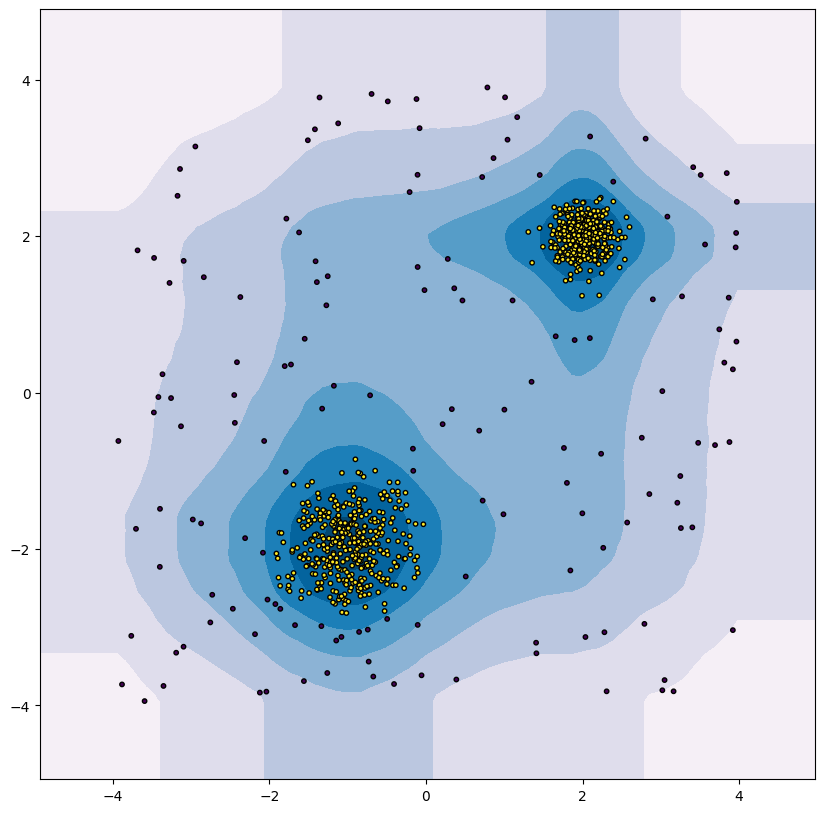

In [ ]:
# @title Обычный Isolation Forest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=5000)

clf.fit(X_train)

_, ax = plt.subplots(figsize=(10, 10))

DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    response_method="score_samples",
    plot_method="contourf",
    ax=ax,
    cmap="PuBu",
)

b1 = plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=clf.predict(X_train),
    s=10,
    edgecolors="k"
)

plt.show()

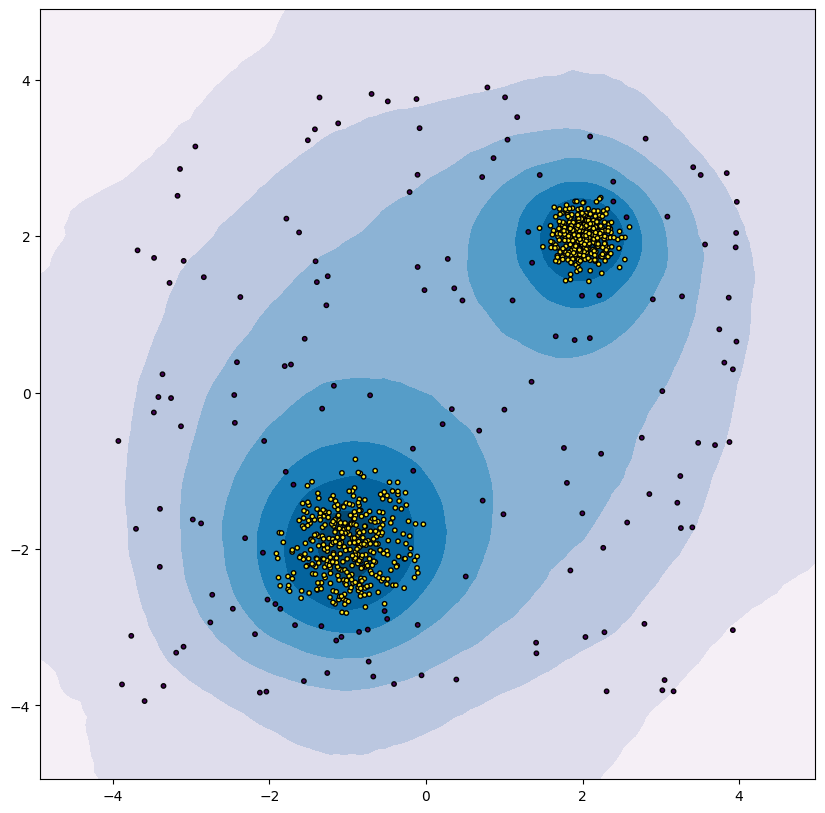

In [ ]:
# @title Rotated Bagging Isolation Forest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import IsolationForest

clf = RotatedIsolationForest(
    num_base_estimators=500,
    n_estimators = 10
)

clf.fit(X_train)

_, ax = plt.subplots(figsize=(10, 10))

DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    response_method="score_samples",
    plot_method="contourf",
    ax=ax,
    cmap="PuBu",
)

b1 = plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=clf.predict(X_train),
    s=10,
    edgecolors="k"
)

plt.show()